In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


def find_new_method(col_name, gisdata, lonNew, latNew, avgConc):
    
    lonNew = lonNew.ravel()
    latNew = latNew.ravel()
    
    # define a function to find the nearest index and value of the grid
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]

    def get_surrounding_indices(i, j, shape):
        return [(i-1, j-1), (i-1, j), (i, j-1), (i, j)]
    
    gisdata[col_name] = 0
    for index, row in gisdata.iterrows():
        lon_idx, nearest_lon = find_nearest(lonNew, row['siteLon'])
        lat_idx, nearest_lat = find_nearest(latNew, row['siteLat'])
        
        dist_to_center = np.sqrt((nearest_lat + 0.005 - row['siteLat'])**2 + 
                                 (nearest_lon + 0.005 - row['siteLon'])**2)
        
        dist_to_cross = np.sqrt((nearest_lat - row['siteLat'])**2 + 
                                (nearest_lon - row['siteLon'])**2)

        # near the center
        if dist_to_center < dist_to_cross:
            gisdata.at[index, col_name] = avgConc[lat_idx, lon_idx]
        else:  # near the cross
            surrounding = get_surrounding_indices(lat_idx, lon_idx, avgConc.shape)
            # calculate the mean value of the surrounding 4 grids
            mean_value = np.mean([avgConc[i, j] for i, j in surrounding if 0 <= i < avgConc.shape[0] and 0 <= j < avgConc.shape[1]])
            gisdata.at[index, col_name] = mean_value

    return gisdata

def find_new_method2(col_name, gisdata, lonNew, latNew, avgConc):
    
    lonNew = lonNew.ravel()
    latNew = latNew.ravel()
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]

    def get_surrounding_indices9(i, j, shape):
        indices = [(i+x, j+y) for x in [-1, 0, 1] for y in [-1, 0, 1]]
        return [(x, y) for x, y in indices if 0 <= x < shape[0] and 0 <= y < shape[1]]
    def get_surrounding_indices4(i, j, shape):
        return [(i-1, j-1), (i-1, j), (i, j-1), (i, j)]
    
    def out_data(pnc_values):
        Q1 = np.percentile(pnc_values, 25)
        Q3 = np.percentile(pnc_values, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = [x for x in pnc_values if x < lower_bound or x > upper_bound]
        return outliers
    
    gisdata[col_name] = None
    values = []
    for index, row in gisdata.iterrows():
        lon_idx, nearest_lon = find_nearest(lonNew, row['siteLon'])
        lat_idx, nearest_lat = find_nearest(latNew, row['siteLat'])      

        surrounding = get_surrounding_indices9(lat_idx, lon_idx, avgConc.shape)
        values.append([avgConc[i, j] for i, j in surrounding])
        temp = [avgConc[i, j] for i, j in surrounding]
        outliers = out_data(temp)
        for outlier in outliers:
            temp.remove(outlier)
        return_mean_data = np.mean(temp)
        gisdata.at[index, col_name] = return_mean_data

    return gisdata, values

def get_gisdata(pollution):
    gisdata = pd.read_csv('../../pncEstimator-main/data/station_gis.csv')
    data = pd.read_csv('../../pncEstimator-main/data/NABEL/pollutants/' + pollution + '.csv', skiprows=6, sep=';')
    data['Date/time'] = pd.to_datetime(data['Date/time'], format='%d.%m.%Y %H:%M')
    data = data[(data['Date/time'] >='2020-01-01 01:00')&(data['Date/time'] < '2021-01-01 01:00')]

    pred_data = pd.read_csv('../../mypred/out/pred_table/pollution_pred/' + pollution + '_data2020_pred.csv')
    pred_data = pred_data.iloc[:, 1:]
    pred_data = pred_data[(pred_data['gbr_pred'] > 0) & (pred_data['lgb_pred'] > 0)]
    pred_data['nabel'] = pred_data['cams'] * pred_data['measurements']
    pred_data['pred_cams_gbr'] = pred_data['cams'] * pred_data['gbr_pred']
    pred_data['pred_cams_lgb'] = pred_data['cams'] * pred_data['lgb_pred']
    pred_data_mean = pred_data.groupby('sta', as_index=False).mean()
    pred_data_mean = pred_data_mean[['sta', 'cams', 'nabel', 'pred_cams_gbr', 'pred_cams_lgb']]
    pred_data_std = pred_data.groupby('sta', as_index=False).std()
    pred_data_std = pred_data_std[['sta', 'cams', 'nabel', 'pred_cams_gbr', 'pred_cams_lgb']]
    pred_data_std.columns = ['sta_std', 'cams_std', 'nabel_std', 'pred_cams_gbr_std', 'pred_cams_lgb_std']

    pnc_values = []
    camsmat = os.listdir('../../pncEstimator-main/src/postProcessing/matdata/pollution/')
    for cams in camsmat:
        if cams.endswith('.mat'):
            if pollution in cams:
                print(cams)
                mat = loadmat('../../pncEstimator-main/src/postProcessing/matdata/pollution/' + cams)
                lonNew = mat['lonNew']
                latNew = mat['latNew']
                avgConc = mat['avgConc']
                col_name = cams.split('_')[1] + cams.split('_')[2].split('.')[0] +'_avgConc'
                gisdata, values  = find_new_method2(col_name, gisdata, lonNew, latNew, avgConc)
                pnc_values.append(values)
    
    # get the average and std of each station
    avg_by_station = pd.DataFrame(data.mean()).iloc[1:]
    std_by_station = pd.DataFrame(data.std()).iloc[1:]
    avg_by_station.index.name = 'station'
    avg_by_station = avg_by_station.reset_index()
    avg_by_station.columns = ['station', 'avg_' + pollution]
    std_by_station.index.name = 'station'
    std_by_station = std_by_station.reset_index()
    std_by_station.columns = ['station', 'std_' + pollution]
    merged_df = pd.merge(avg_by_station, gisdata, left_on='station', right_on='station2', how='inner')
    merged_df = pd.merge(std_by_station, merged_df, left_on='station', right_on='station2', how='inner')
    merged_df = pd.merge(pred_data_mean, merged_df, left_on='sta', right_on='stn', how='right')
    merged_df = pd.merge(pred_data_std, merged_df, left_on='sta_std', right_on='stn', how='right')
    # print(merged_df.columns)
    return merged_df, gisdata, pnc_values

2020NOXavgConc_lgb_exp.mat


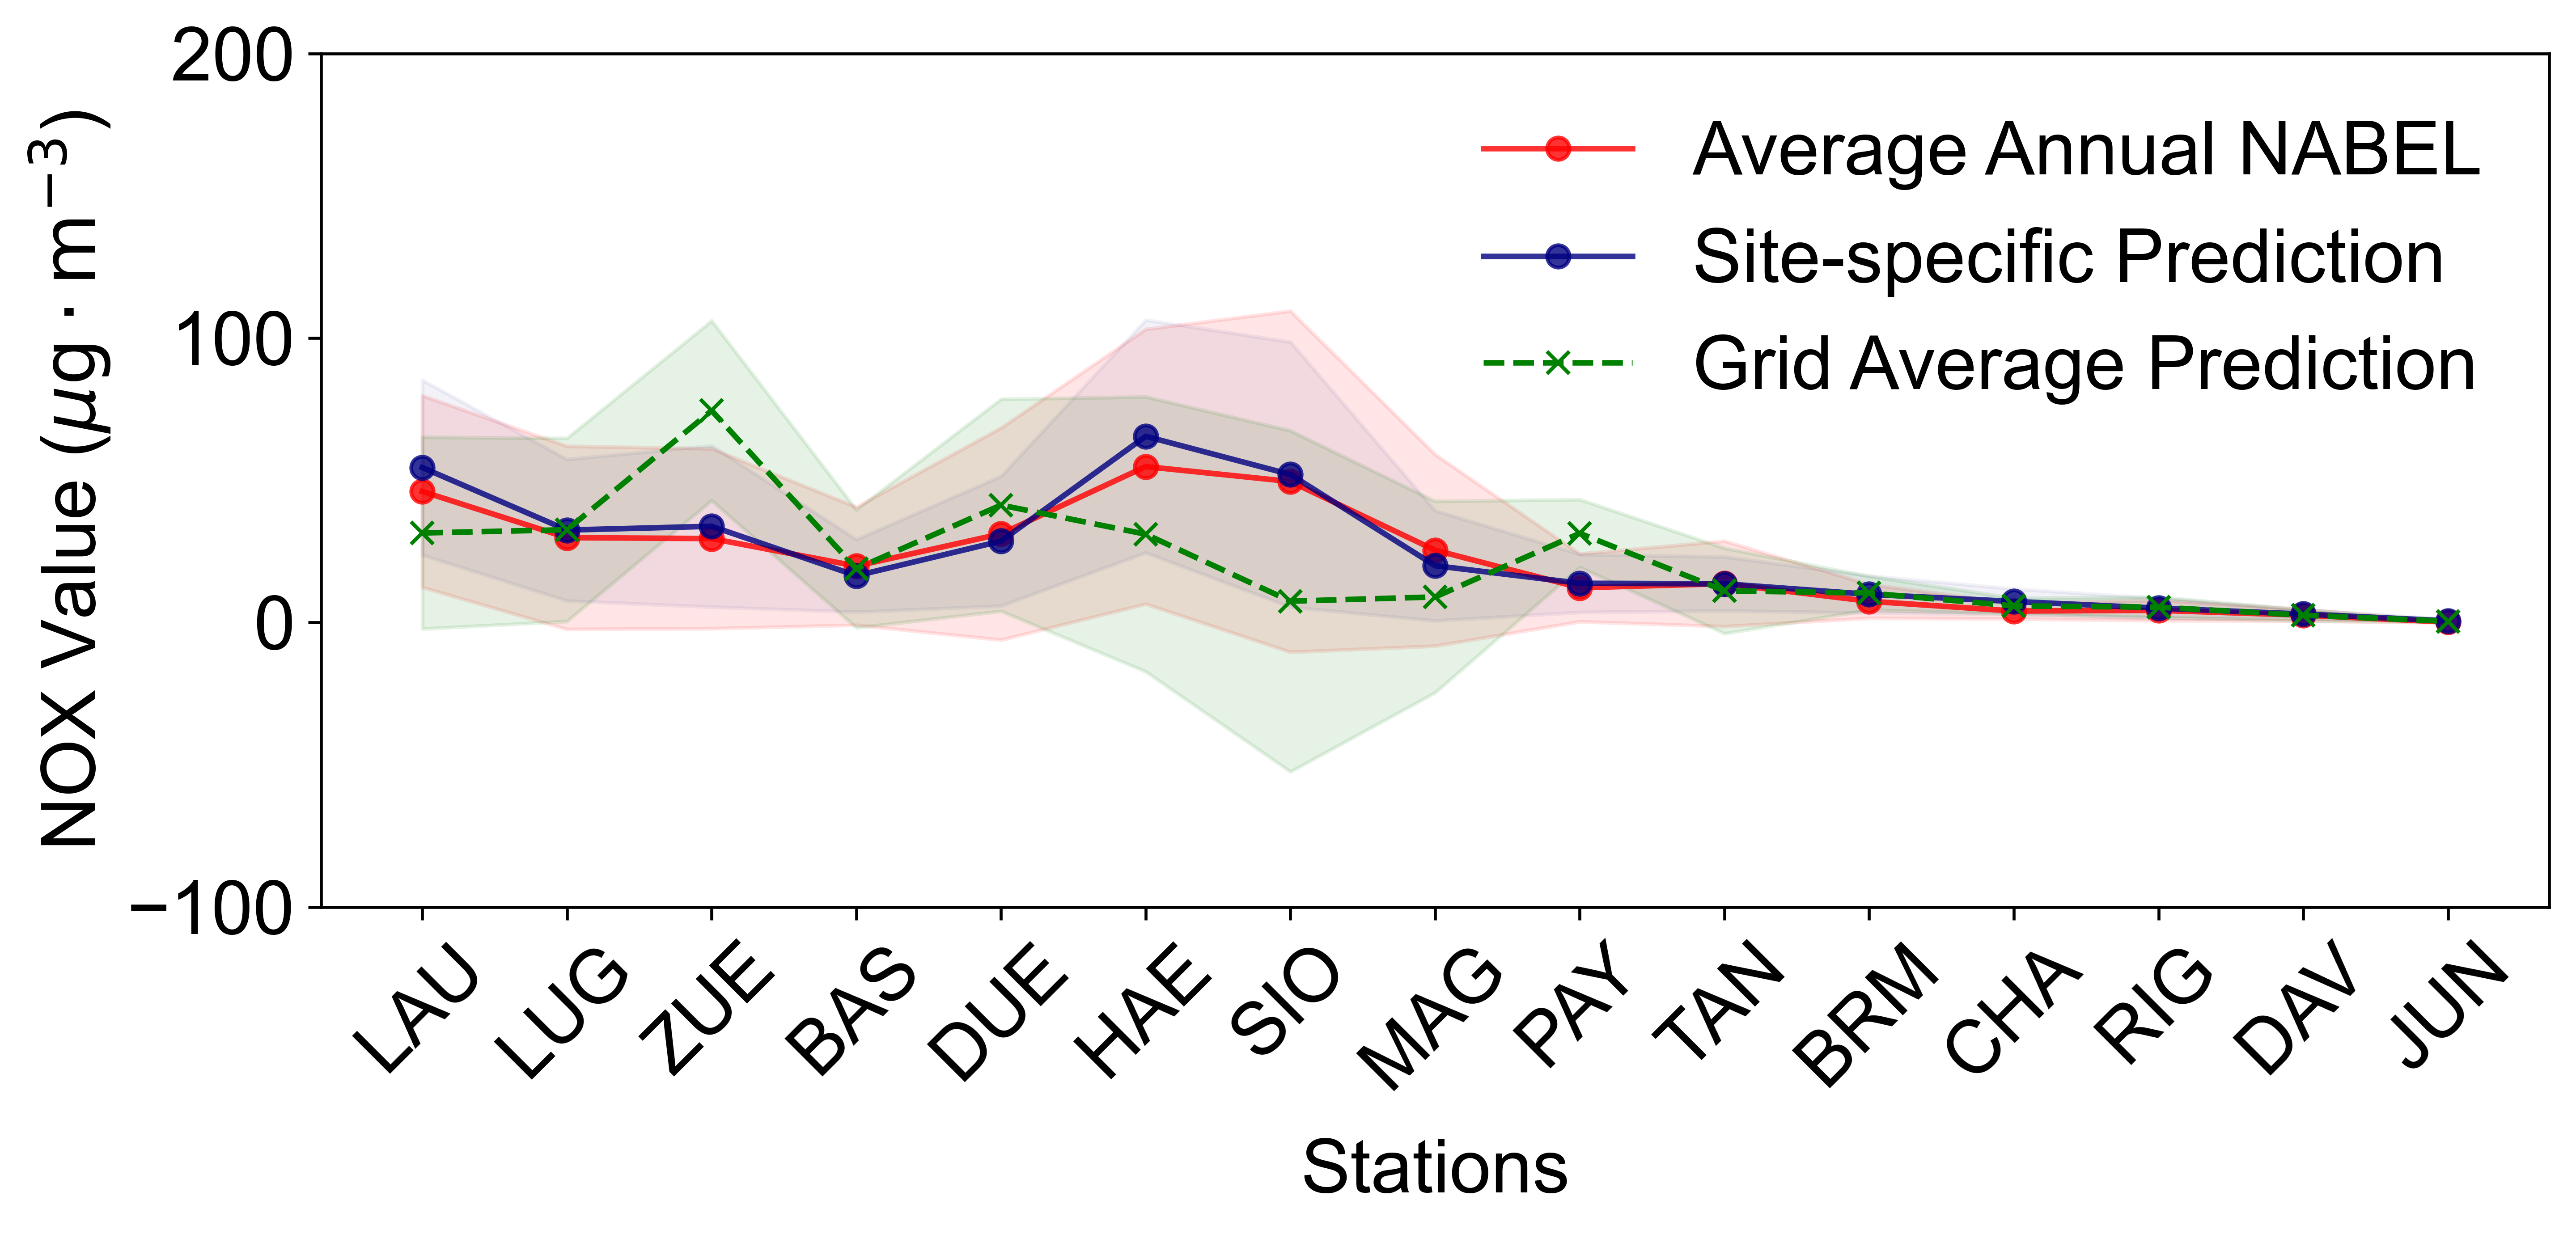

In [2]:
plt.figure(figsize=(10, 5), dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20

pollution = 'NOX'
merged_df, gisdata, pnc_values = get_gisdata(pollution)

avg_name = 'avg_' + pollution
std_name = 'std_' + pollution
merged_df[avg_name] = merged_df[avg_name].astype(float)
merged_df[std_name] = merged_df[std_name].astype(float)
plt.plot(merged_df['stn'], merged_df[avg_name], marker='o',
         label='Average Annual NABEL', color='red',alpha=0.8)
upper_bound_cpc = merged_df[avg_name] + merged_df[std_name]
lower_bound_cpc = merged_df[avg_name] - merged_df[std_name]
plt.fill_between(merged_df['stn'], lower_bound_cpc, upper_bound_cpc, color='red', alpha=0.1)

plt.plot(merged_df['stn'], merged_df['pred_cams_lgb'], marker='o',
         label='Site-specific Prediction', color='navy', alpha=0.8)
upper_bound_cams = merged_df['pred_cams_lgb'] + merged_df['pred_cams_lgb_std']
lower_bound_cams = merged_df['pred_cams_lgb'] - merged_df['pred_cams_lgb_std']
plt.fill_between(merged_df['stn'], lower_bound_cams, upper_bound_cams, color='navy', alpha=0.05)


colors = ['green']
color_idx = 0

select_pollution = 'lgbexp_'
for column in gisdata.columns:
    if  select_pollution + 'avgConc' in column:
        current_color = colors[color_idx % len(colors)]
        color_idx += 1
        plt.plot(merged_df['stn'], merged_df[column], marker='x', label='Grid Average Prediction',
                 color=current_color, linestyle='--')

        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce')
        merged_df['std_'+pollution] = pd.to_numeric(merged_df['std_'+pollution], errors='coerce')
        upper_bound = merged_df[column] + merged_df['std_'+pollution]
        lower_bound = merged_df[column] - merged_df['std_'+pollution]
        plt.fill_between(merged_df['stn'], lower_bound, upper_bound, color=current_color, alpha=0.1)

plt.legend(edgecolor='k', facecolor='none', frameon = False, loc='upper right')
plt.xlabel("Stations", fontsize=20, labelpad=10)
# plt.ylabel(pollution + r" Value ($\mu g\cdot m^{-3}$)", fontsize=20)
plt.ylabel(pollution + r" Value ($\mu \mathrm{g}\cdot \mathrm{m}^{-3}$)", fontsize=20)
plt.ylim([-100, 200])
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
plt.savefig('figure/'+pollution+'_compare.png', dpi=600)
plt.show()

2020NO2avgConc_gbr_square.mat


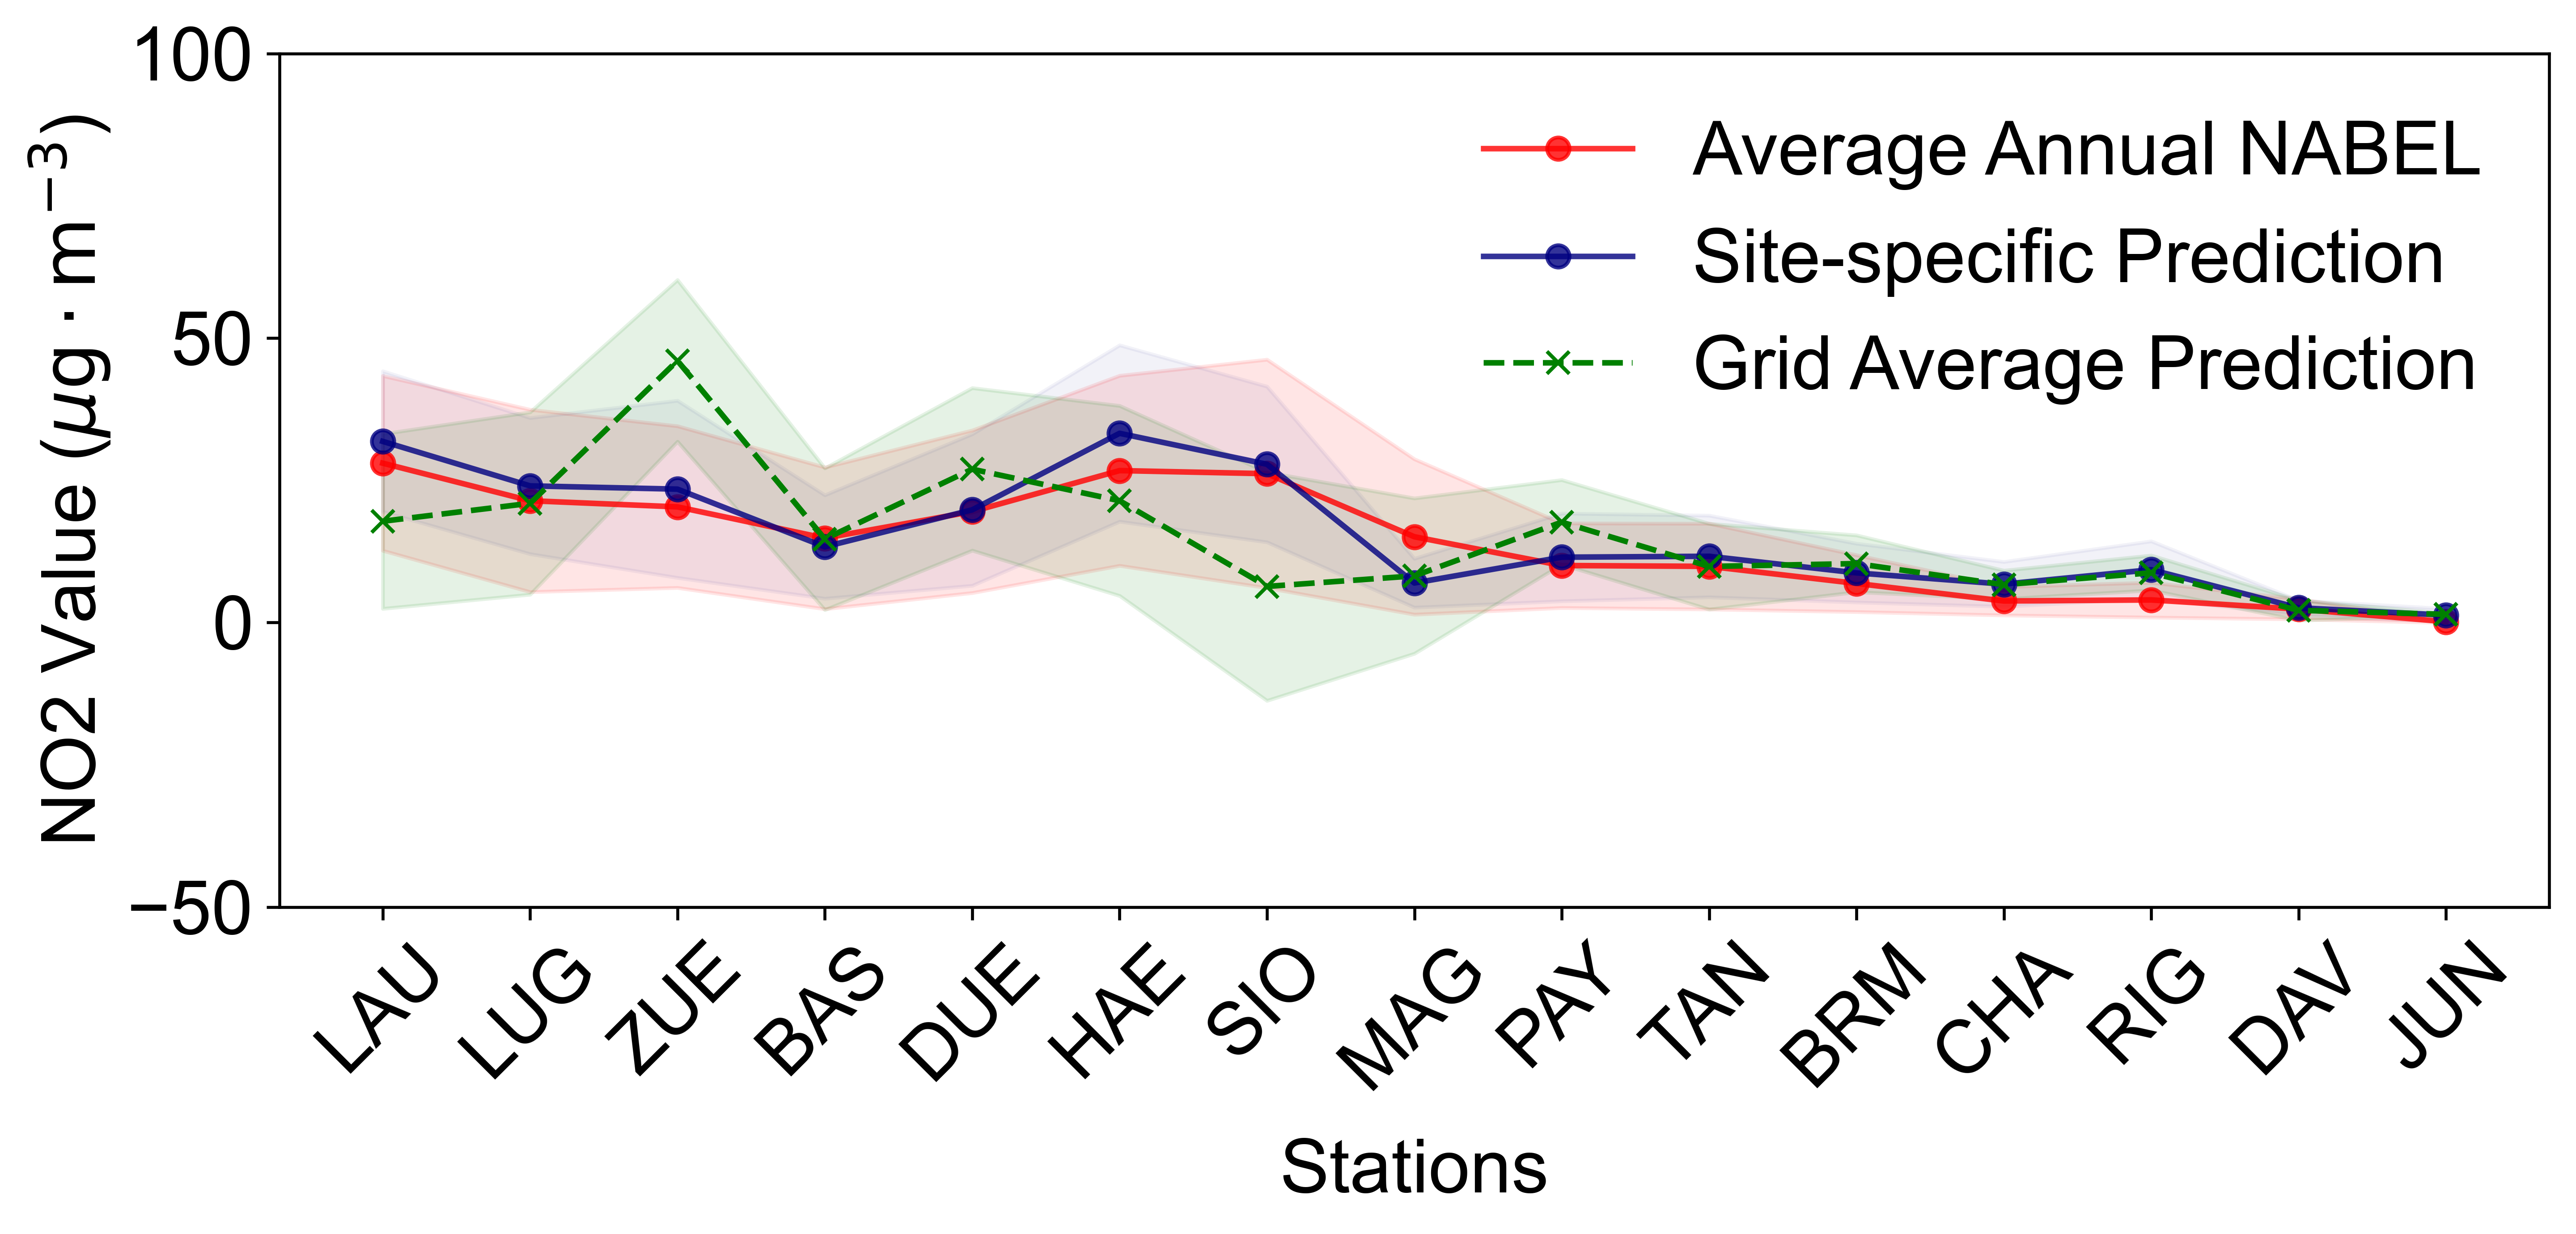

In [3]:
plt.figure(figsize=(10, 5), dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20

pollution = 'NO2'
merged_df, gisdata, pnc_values = get_gisdata(pollution)

avg_name = 'avg_' + pollution
std_name = 'std_' + pollution
merged_df[avg_name] = merged_df[avg_name].astype(float)
merged_df[std_name] = merged_df[std_name].astype(float)
plt.plot(merged_df['stn'], merged_df[avg_name], marker='o', label='Average Annual NABEL', color='red',alpha=0.8)
upper_bound_cpc = merged_df[avg_name] + merged_df[std_name]
lower_bound_cpc = merged_df[avg_name] - merged_df[std_name]
plt.fill_between(merged_df['stn'], lower_bound_cpc, upper_bound_cpc, color='red', alpha=0.1)

plt.plot(merged_df['stn'], merged_df['pred_cams_gbr'], marker='o',
         label='Site-specific Prediction', color='navy', alpha=0.8)
upper_bound_cams = merged_df['pred_cams_gbr'] + merged_df['pred_cams_gbr_std']
lower_bound_cams = merged_df['pred_cams_gbr'] - merged_df['pred_cams_gbr_std']
plt.fill_between(merged_df['stn'], lower_bound_cams, upper_bound_cams, color='navy', alpha=0.05)

colors = ['green']
color_idx = 0

select_pollution = 'gbrsquare_'
for column in gisdata.columns:
    if select_pollution + 'avgConc' in column:
        current_color = colors[color_idx % len(colors)]
        color_idx += 1
        plt.plot(merged_df['stn'], merged_df[column], marker='x', label='Grid Average Prediction',
                 color=current_color, linestyle='--')
        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce')
        merged_df['std_'+pollution] = pd.to_numeric(merged_df['std_'+pollution], errors='coerce')
        upper_bound = merged_df[column] + merged_df['std_'+pollution]
        lower_bound = merged_df[column] - merged_df['std_'+pollution]
        plt.fill_between(merged_df['stn'], lower_bound, upper_bound, color=current_color, alpha=0.1)

plt.legend(edgecolor='k', facecolor='none', frameon = False, loc='upper right')
plt.xlabel("Stations", fontsize=20, labelpad=10)
# plt.ylabel(pollution + r" Value ($\mu g\cdot m^{-3}$)", fontsize=20)
plt.ylabel(pollution + r" Value ($\mu \mathrm{g}\cdot \mathrm{m}^{-3}$)", fontsize=20)
plt.ylim([-50, 100])
# plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figure/'+pollution+'_compare.png', dpi=600)
plt.show()

2020PM10avgConc_lgb_square.mat


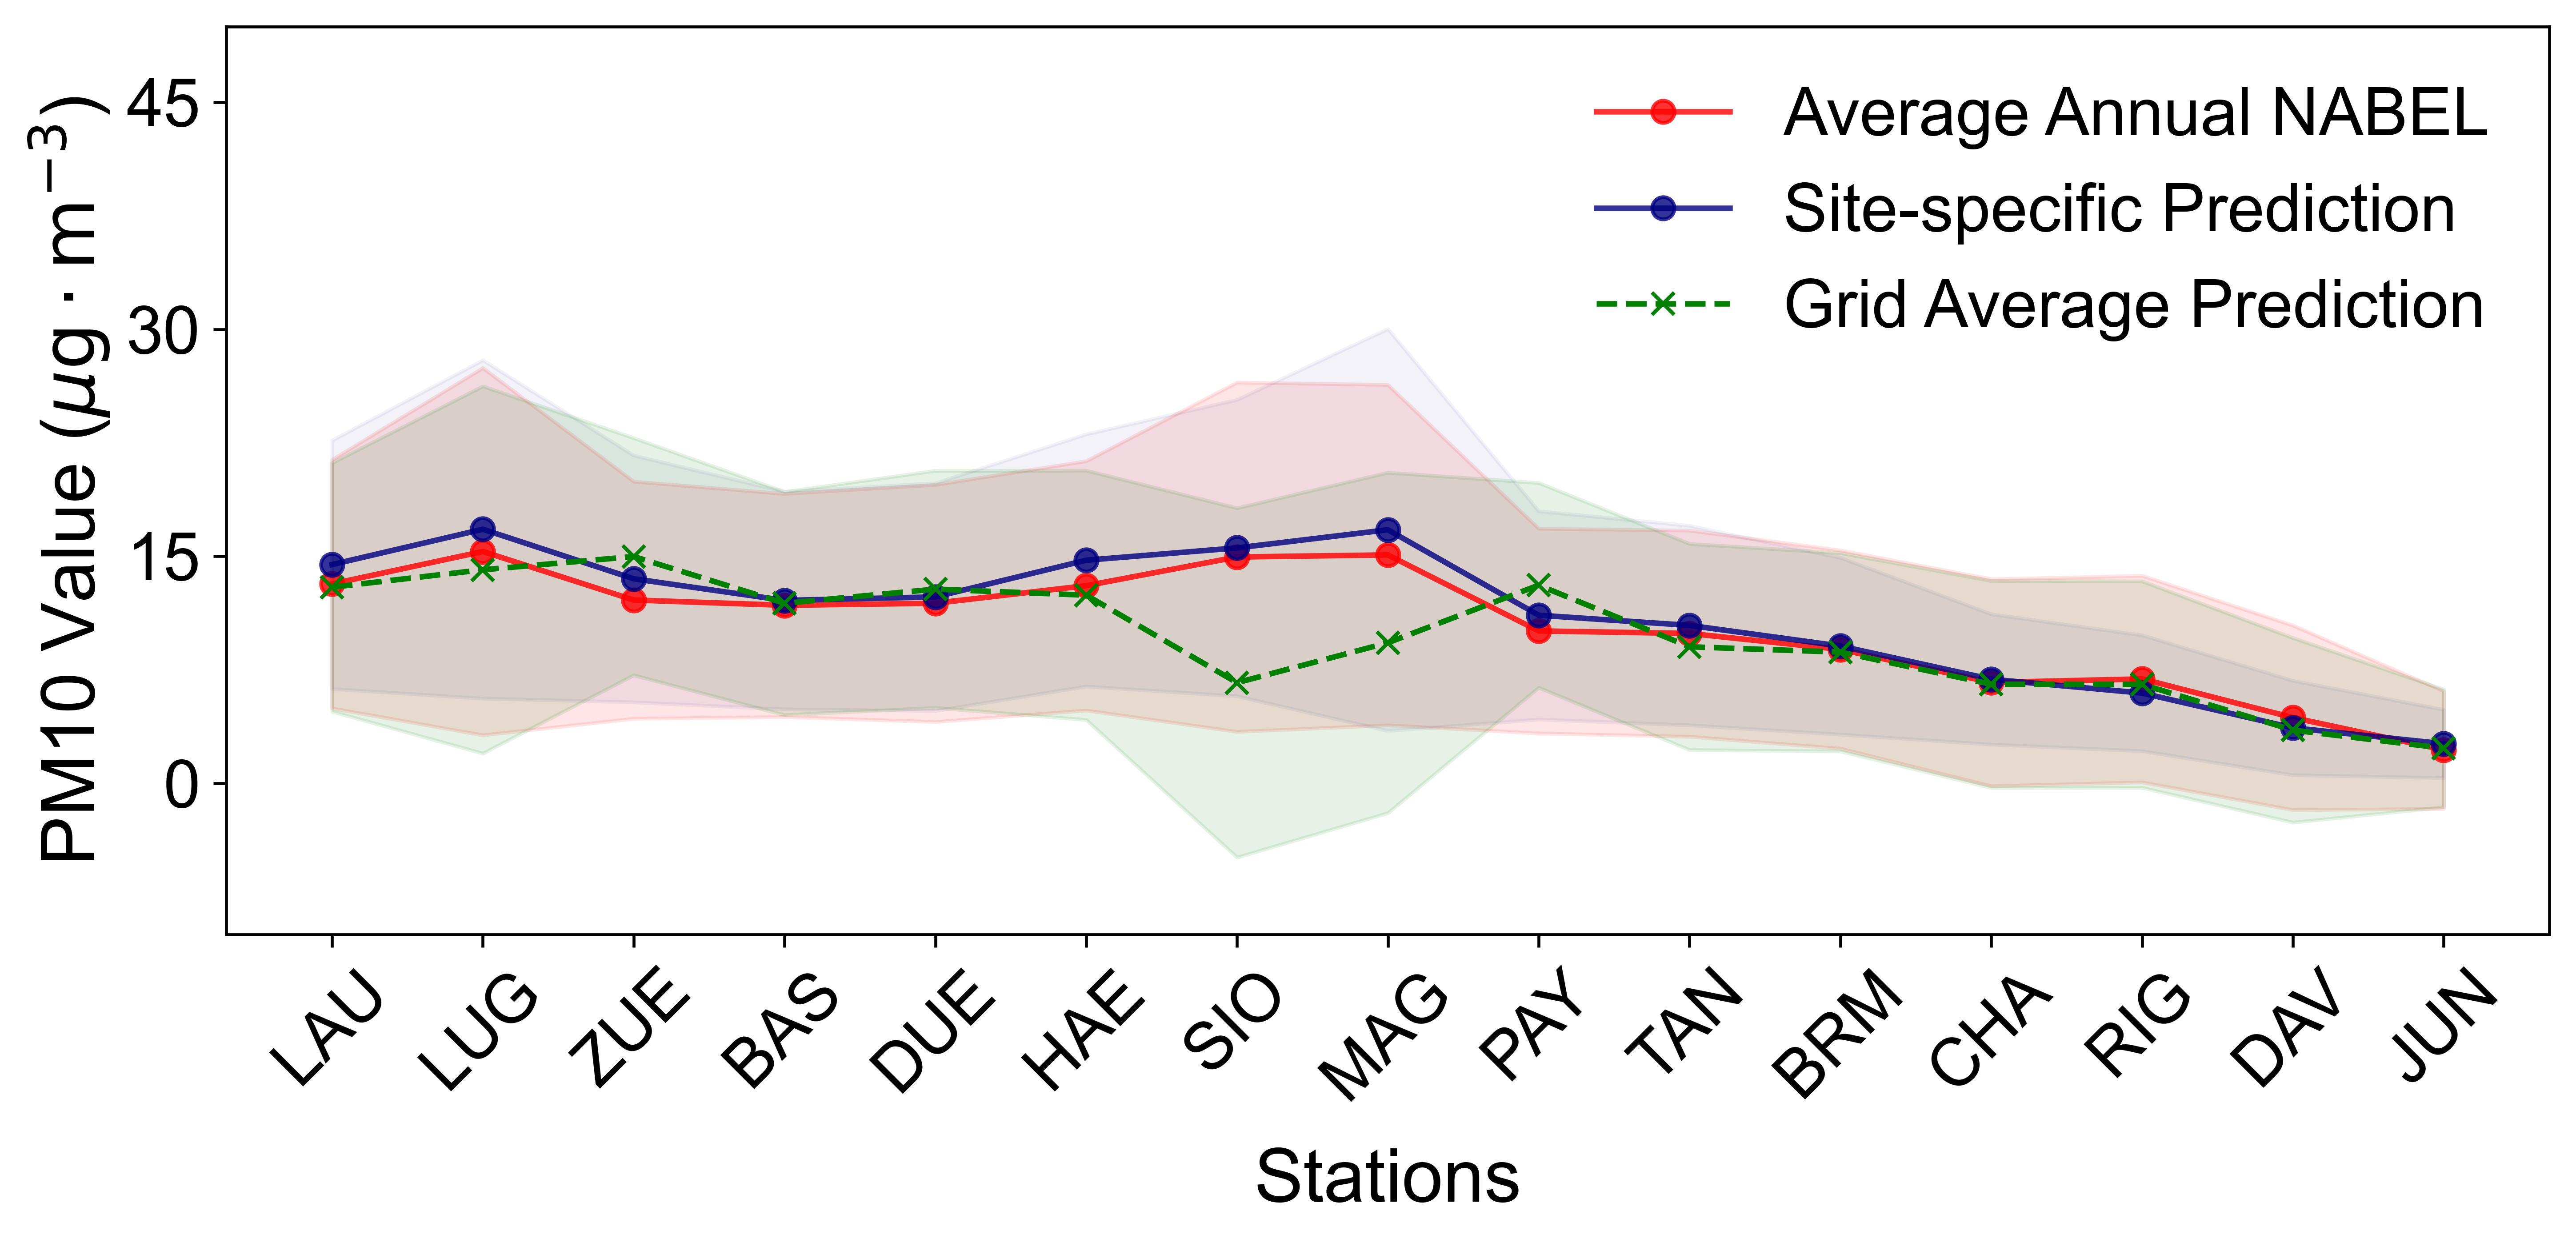

In [6]:
plt.figure(figsize=(10, 5), dpi=600)
from matplotlib.ticker import MaxNLocator, FixedLocator
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

pollution = 'PM10'
merged_df, gisdata, _ = get_gisdata(pollution)

avg_name = 'avg_' + pollution
std_name = 'std_' + pollution
merged_df[avg_name] = merged_df[avg_name].astype(float)
merged_df[std_name] = merged_df[std_name].astype(float)
plt.plot(merged_df['stn'], merged_df[avg_name], marker='o', label='Average Annual NABEL', color='red',alpha=0.8)
upper_bound_cpc = merged_df[avg_name] + merged_df[std_name]
lower_bound_cpc = merged_df[avg_name] - merged_df[std_name]
plt.fill_between(merged_df['stn'], lower_bound_cpc, upper_bound_cpc, color='red', alpha=0.1)

plt.plot(merged_df['stn'], merged_df['pred_cams_lgb'], marker='o',
         label='Site-specific Prediction', color='navy', alpha=0.8)
upper_bound_cams = merged_df['pred_cams_lgb'] + merged_df['pred_cams_lgb_std']
lower_bound_cams = merged_df['pred_cams_lgb'] - merged_df['pred_cams_lgb_std']
plt.fill_between(merged_df['stn'], lower_bound_cams, upper_bound_cams, color='navy', alpha=0.05)

colors = ['green']
color_idx = 0

select_pollution = 'lgbsquare_'
for column in gisdata.columns:
    if select_pollution + 'avgConc' in column:
        current_color = colors[color_idx % len(colors)]
        color_idx += 1
        plt.plot(merged_df['stn'], merged_df[column], marker='x', label='Grid Average Prediction',
                 color=current_color, linestyle='--')
        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce')
        merged_df['std_'+pollution] = pd.to_numeric(merged_df['std_'+pollution], errors='coerce')
        upper_bound = merged_df[column] + merged_df['std_'+pollution]
        lower_bound = merged_df[column] - merged_df['std_'+pollution]
        plt.fill_between(merged_df['stn'], lower_bound, upper_bound, color=current_color, alpha=0.1)

plt.legend(edgecolor='k', facecolor='none', frameon = False, loc='upper right')
plt.xticks(rotation=45)
plt.xlabel("Stations", fontsize=20, labelpad=10)
plt.gca().yaxis.set_major_locator(MaxNLocator(4))
plt.ylabel(pollution + r" Value ($\mu \mathrm{g}\cdot \mathrm{m}^{-3}$)", fontsize=20)
plt.ylim([-10, 50])
# plt.grid(True)
plt.tight_layout()
plt.savefig('figure/'+pollution+'_compare.png', dpi=600)
plt.show()

2020PM2.5avgConc_gbr_square.mat


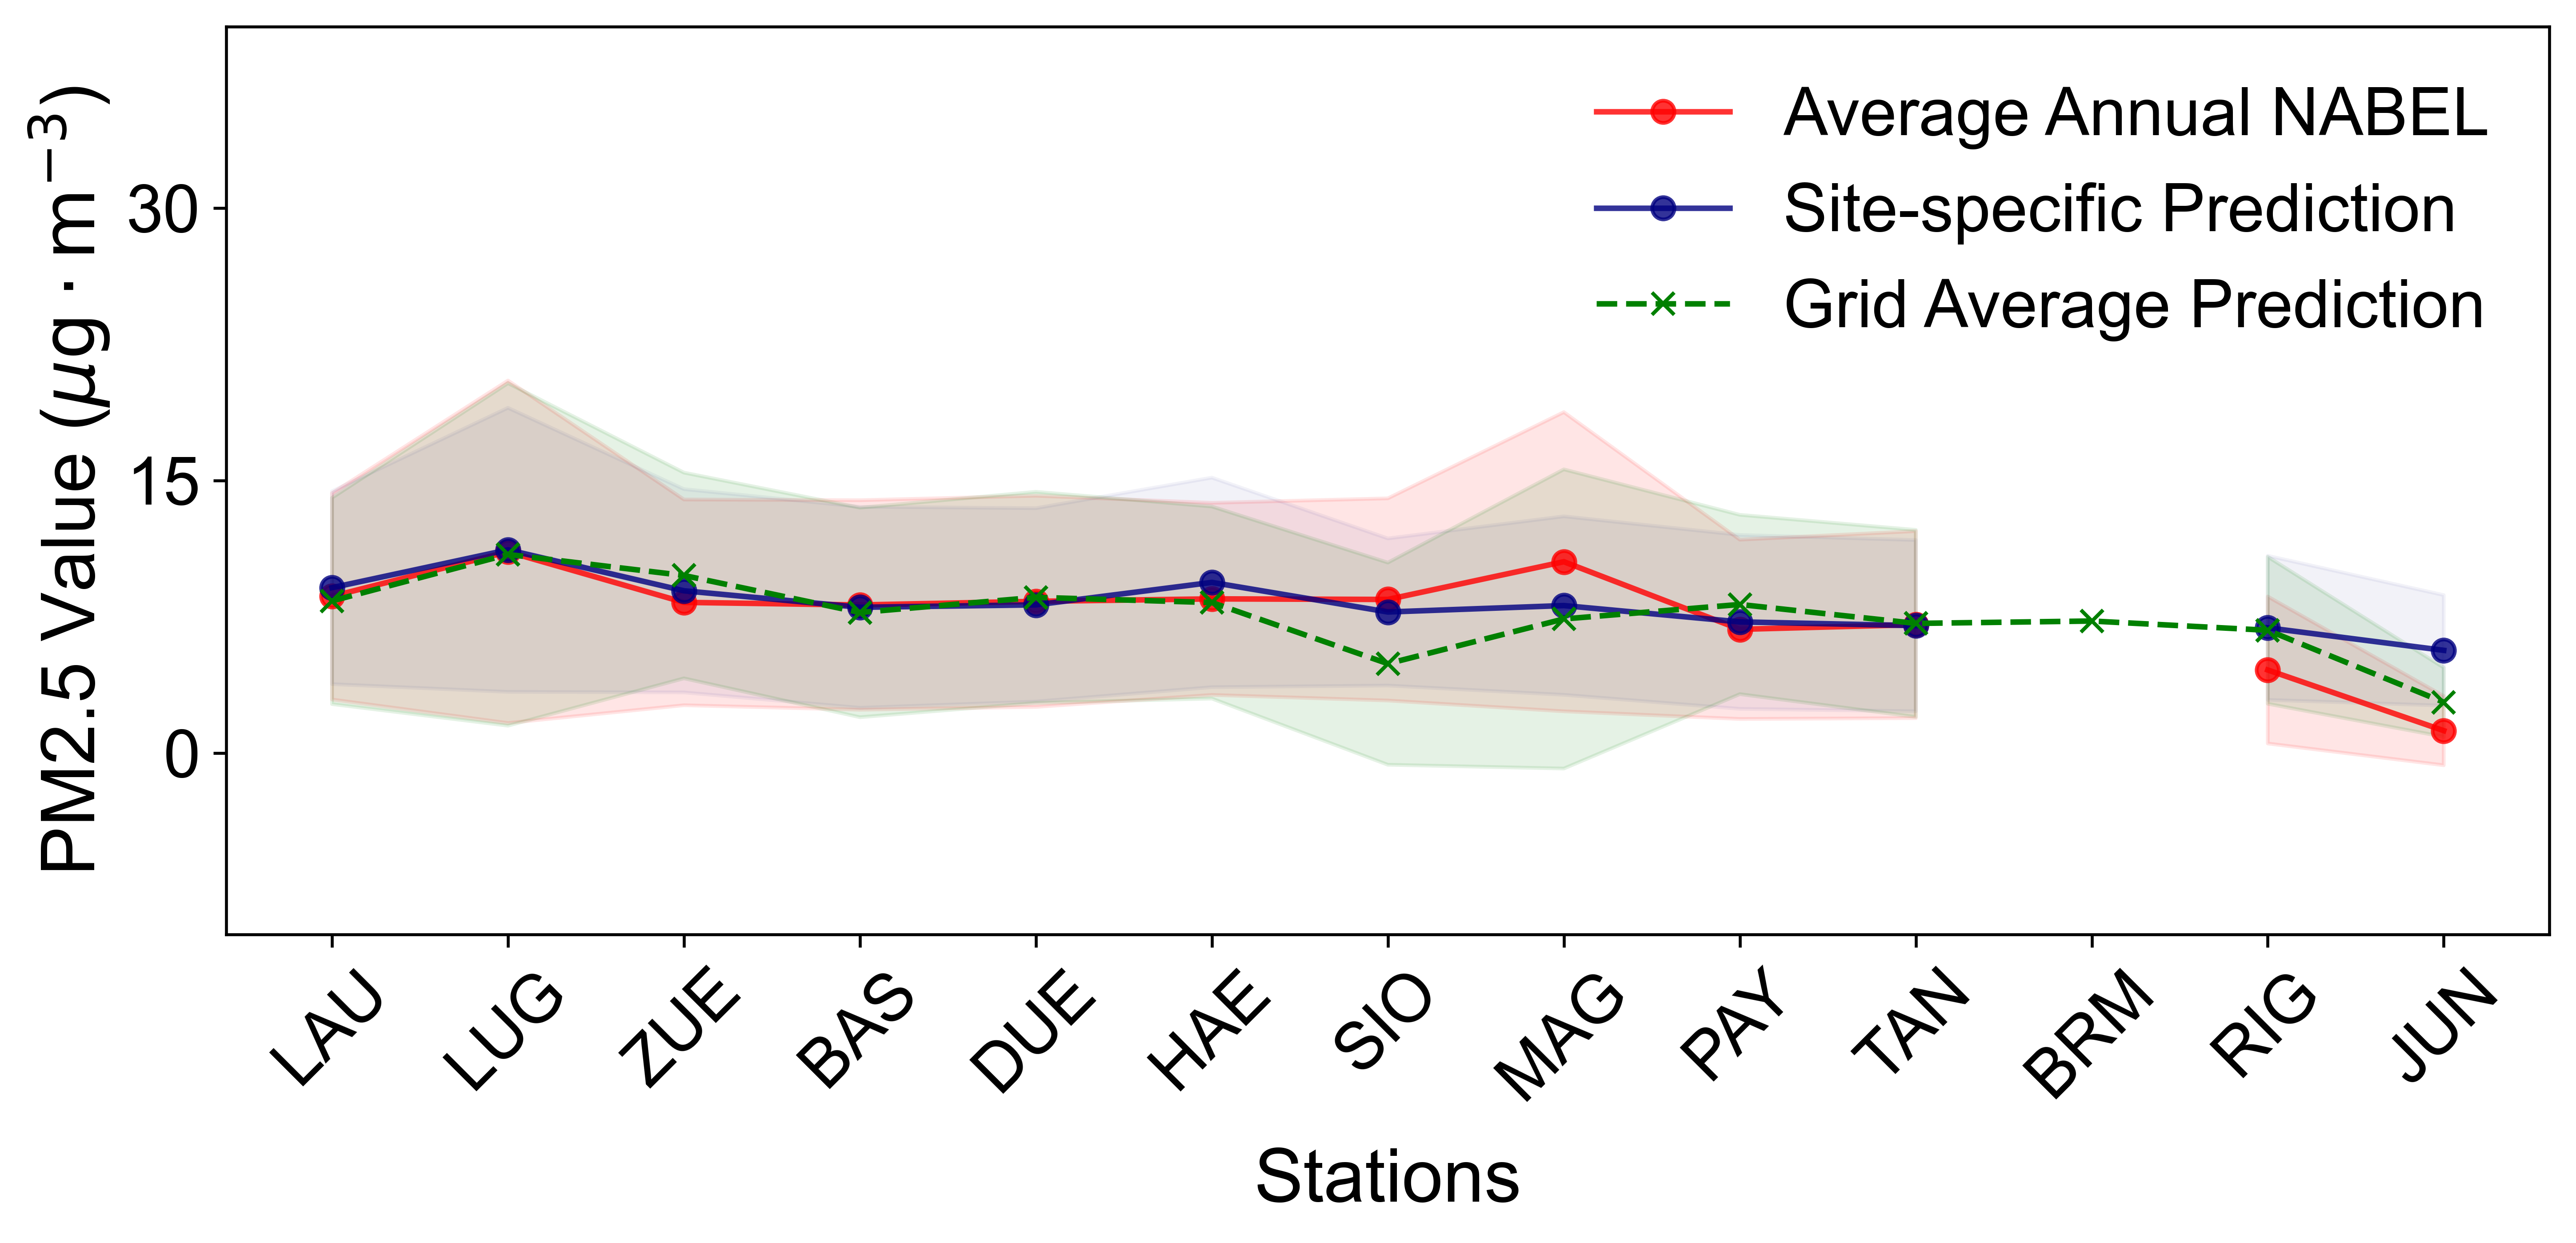

In [8]:
plt.figure(figsize=(10, 5), dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

pollution = 'PM2.5'
merged_df, gisdata, _ = get_gisdata(pollution)

avg_name = 'avg_' + pollution
std_name = 'std_' + pollution
merged_df[avg_name] = merged_df[avg_name].astype(float)
merged_df[std_name] = merged_df[std_name].astype(float)
plt.plot(merged_df['stn'], merged_df[avg_name], marker='o', label='Average Annual NABEL', color='red',alpha=0.8)
upper_bound_cpc = merged_df[avg_name] + merged_df[std_name]
lower_bound_cpc = merged_df[avg_name] - merged_df[std_name]
plt.fill_between(merged_df['stn'], lower_bound_cpc, upper_bound_cpc, color='red', alpha=0.1)

plt.plot(merged_df['stn'], merged_df['pred_cams_gbr'], marker='o',
         label='Site-specific Prediction', color='navy', alpha=0.8)
upper_bound_cams = merged_df['pred_cams_gbr'] + merged_df['pred_cams_gbr_std']
lower_bound_cams = merged_df['pred_cams_gbr'] - merged_df['pred_cams_gbr_std']
plt.fill_between(merged_df['stn'], lower_bound_cams, upper_bound_cams, color='navy', alpha=0.05)


colors = ['green']
color_idx = 0

select_pollution = 'gbrsquare_'
for column in gisdata.columns:
    if select_pollution + 'avgConc' in column:
        current_color = colors[color_idx % len(colors)]
        color_idx += 1
        plt.plot(merged_df['stn'], merged_df[column], marker='x', label='Grid Average Prediction',
                 color=current_color, linestyle='--')
        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce')
        merged_df['std_'+pollution] = pd.to_numeric(merged_df['std_'+pollution], errors='coerce')
        upper_bound = merged_df[column] + merged_df['std_'+pollution]
        lower_bound = merged_df[column] - merged_df['std_'+pollution]
        plt.fill_between(merged_df['stn'], lower_bound, upper_bound, color=current_color, alpha=0.1)

plt.legend(edgecolor='k', facecolor='none', frameon = False, loc='upper right')
plt.xticks(rotation=45)
plt.xlabel("Stations", fontsize=20, labelpad=10)
plt.gca().yaxis.set_major_locator(MaxNLocator(4))
plt.ylabel(pollution + r" Value ($\mu \mathrm{g}\cdot \mathrm{m}^{-3}$)", fontsize=20)
plt.ylim([-10, 40])

plt.tight_layout()
plt.savefig('figure/PM2_5_compare.png', dpi=600)
plt.show()